# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
PATH_TO_ENV = "Reacher_Linux/Reacher.x86"
BRAIN = "ReacherBrain"
TRAINING = True

env = UnityEnvironment(file_name=PATH_TO_ENV, no_graphics=TRAINING)

ACTION_SIZE = env.brains[BRAIN].vector_action_space_size
STATE_SIZE = env.brains[BRAIN].vector_observation_space_size

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[BRAIN]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
print('Size of each action:', ACTION_SIZE)

# examine the state space 
states = env_info.vector_observations
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], STATE_SIZE))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


# Convenience functions

In [4]:
def act(env, actions, brain_name=BRAIN) -> tuple:
    """Sends actions to the environment env and observes the results.
    Returns a tuple of rewards, next_states, dones (One per agent)"""
    action_result = env.step(actions)[brain_name] # Act on the environment and observe the result
    return (action_result.rewards,
            action_result.vector_observations, # next states
            action_result.local_done) # True if the episode ended
    
def reset(env, training=TRAINING, brain_name=BRAIN) -> np.ndarray:
    """Syntactic sugar for resetting the unity environment"""
    return env.reset(train_mode=training)[brain_name].vector_observations

# Prepare the training

In [5]:
#from IPython.display import clear_output
np.set_printoptions(precision=3, suppress=True)

In [6]:
# Profiling (optional)
import cProfile
profiling = False # Set to True to profile execution time
if profiling:
    profile = cProfile.Profile()

In [7]:
# Invite our agent & import utils
from ddpg_agent import Agent
import torch

In [8]:
def train(agent, env, num_episodes, log_freq, max_t=20000, profiling=False, profile=None):        
    score_hist = np.zeros((num_agents, 1))
    if profiling: 
        profile.enable()
    
    # Train
    for i in range(num_episodes):
        states = reset(env)
        scores = np.zeros(num_agents)
        for j in range(max_t): # Safer than while
            # Decide
            #state = states.squeeze() # One agent only
            actions = agent.decide(states)  # Choose an action based on the state
            #actions = np.expand_dims(action, 0) # One agent only
            # Act
            rewards, next_states, dones = act(env, actions)     # Send the actions to the environment
            scores += rewards                         # update the score (for each agent)
            # Learn
            agent.step(states, actions, rewards[0], next_states[0], dones[0]) # Learn step
            # Step
            states = next_states                               # roll over states to next time step
            # Exit
            if np.any(dones):                                  # exit loop if episode finished
                break       
        # Logging
        score_hist = np.concatenate((score_hist, scores[:, None]), axis=1)
        if (i % log_freq == 0) and (i > 0):
            print(f'Avg. score episodes {i-log_freq+1}-{i+1}: {np.mean(score_hist.squeeze()[-log_freq:])}')
        
        if np.mean(score_hist.squeeze()[-100:]) >= 30:
            print(f'Solved in {i} steps!')
            break

    if profiling: 
        profile.disable()
        
    return score_hist.squeeze()

In [9]:
%%time
agent = Agent(STATE_SIZE, ACTION_SIZE, np.random.randint(1e5), cuda=True)
score_hist = train(agent, env, num_episodes=500, log_freq=10)

Avg. score episodes 1-11: 0.2679999940097332
Avg. score episodes 11-21: 0.6899999845772982
Avg. score episodes 21-31: 1.1569999741390347
Avg. score episodes 31-41: 1.6389999633654952
Avg. score episodes 41-51: 2.4229999458417297
Avg. score episodes 51-61: 3.601999919489026
Avg. score episodes 61-71: 3.996999910660088
Avg. score episodes 71-81: 3.7899999152868986
Avg. score episodes 81-91: 4.737999894097447
Avg. score episodes 91-101: 5.104999885894358
Avg. score episodes 101-111: 7.489999832585454
Avg. score episodes 111-121: 7.8079998254776
Avg. score episodes 121-131: 8.593999807909132
Avg. score episodes 131-141: 8.952999799884855
Avg. score episodes 141-151: 9.572999786026775
Avg. score episodes 151-161: 8.524999809451401
Avg. score episodes 161-171: 12.749999715015292
Avg. score episodes 171-181: 12.689999716356397
Avg. score episodes 181-191: 18.52599958591163
Avg. score episodes 191-201: 17.456999609805642
Avg. score episodes 201-211: 18.10099959541112
Avg. score episodes 211-22

# Plotting + visualizing

In [10]:
from matplotlib import pyplot as plt
#import seaborn as sns

In [11]:
def moving_average(signal:np.ndarray , period: int):
    buffer = [np.nan] * period
    for i in range(period,len(signal)):
        buffer.append(signal[i-period:i].mean())
    return np.array(buffer)

#def moving_std(signal:np.ndarray , period: int):
#    buffer = [np.nan] * period
#    for i in range(period,len(signal)):
#        buffer.append(signal[i-period:i].std())
#    return np.array(buffer)

(0, 500)

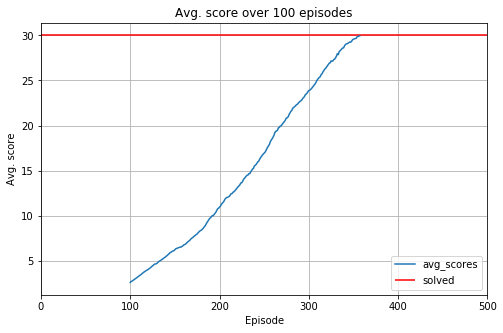

In [17]:
length = 100
avg_scores = moving_average(score_hist, length)
plt.figure(figsize=(8,5))
plt.plot(avg_scores, label='avg_scores')
plt.hlines(30, xmin=0, xmax=500, colors='r', label='solved')
plt.grid()
plt.xlabel('Episode')
plt.ylabel('Avg. score')
plt.title(f'Avg. score over {length} episodes')
plt.legend(loc='lower right')
plt.xlim((0, 500))

# Save models

In [13]:
from datetime import datetime
def save_agent(agent, name=None, avg_scores=None):
    """Saves the agent's parameters and the underlying pytorch model"""
    checkpoint = {'actor_state_dict': agent.actor_local.state_dict(),
                  'critic_state_dict': agent.critic_local.state_dict(),
                  'score_hist': score_hist}
    if not name:
        # Standard name: score-episodes-date
        name = f'{round(avg_scores[-1],1)}-{len(avg_scores)}-{datetime.strftime(datetime.now(),"%d.%m.%y_%H.%M")}'
        
    torch.save(checkpoint, f'models/{name}-checkpoint.pth')

In [14]:
save_agent(agent, avg_scores=avg_scores)

In [15]:
env.close()